# Introduction

As you saw in the previous notebook on Vanilla GAN, we don't have any control over the digits that are generated. However we can force the generator to generate a particular digit by giving the labels as the input to the generator. As you will see, we need to give these labels to both the generator and discrminator during the training process.

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# DataSet

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


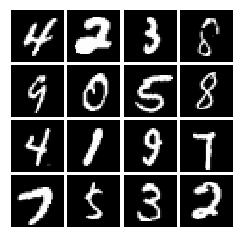

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

# show a batch
show_images(mnist.train.next_batch(16)[0])

### Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

In [4]:
def sample_labels(batch_size, dim):
    """Generate one hot random labels.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing one-hot labels with shape [batch_size, dim]
    """
    labels = tf.random_uniform([batch_size, dim], 0, 1)
    return tf.one_hot(tf.argmax(labels, axis=1), dim)

### Discrmiminator

In [10]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images along with its labels, shape [batch_size, 784 + 10]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        layer_1 = tf.layers.dense(x, 256, tf.nn.leaky_relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 256, tf.nn.leaky_relu, name="layer_2")
        logits = tf.layers.dense(layer_2, 1, name="logit")
        return logits

### Generator

In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim + label_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        layer_1 = tf.layers.dense(z, 1024, tf.nn.relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 1024, tf.nn.relu, name="layer_2")
        img = tf.layers.dense(layer_2, 784, tf.nn.tanh, name="image")
        return img

### GAN loss

In [7]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    ones_labels_d = tf.ones_like(logits_real) 
    zeros_labels_d = tf.zeros_like(logits_fake)
    
    ones_labels_g = tf.ones_like(logits_fake)
    
    real_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=ones_labels_d)
    fake_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=zeros_labels_d)
    D_loss = tf.reduce_mean(real_data_predictions) + tf.reduce_mean(fake_data_predictions)
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=ones_labels_g))
    return D_loss, G_loss

### Optimizers

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

### Putting it all together

In [11]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
labels_dim = 10

# placeholder for images from the training dataset
x_image = tf.placeholder(tf.float32, [None, 784])
# scale images to be -1 to 1
x_image_preprocess = preprocess_img(x_image)
# placeholders for labels
x_label = tf.placeholder(tf.float32, [None, labels_dim])
# concate labels and images
x = tf.concat((x_image_preprocess, x_label), axis=1)

# random image_noise fed into our generator
z_image = sample_noise(batch_size, noise_dim)
# random label_nose fed into the generator
z_label = sample_labels(batch_size, labels_dim)
# concat image and noise
z = tf.concat((z_image, z_label), axis=1)

# generated images
G_sample = generator(z)
# concat generated images with fake labels
G_sample_with_labels = tf.concat((G_sample, z_label), axis=1)

with tf.variable_scope("") as scope:
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample_with_labels)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

### Run a GAN

In [13]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x_image_preprocess: minibatch_x,
                                                                     x_label: minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

# Training

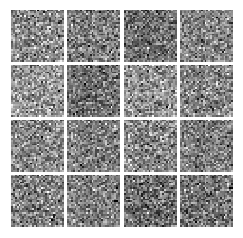


Iter: 0, D: 1.488, G:0.8491
Iter: 50, D: 1.402, G:1.24
Iter: 100, D: 1.403, G:0.8788
Iter: 150, D: 0.8981, G:1.222
Iter: 200, D: 0.92, G:1.928


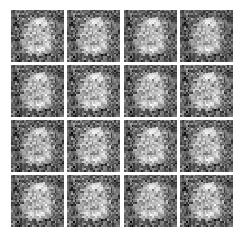


Iter: 250, D: 1.179, G:1.957
Iter: 300, D: 1.556, G:3.216
Iter: 350, D: 1.688, G:2.817
Iter: 400, D: 0.9913, G:1.577
Iter: 450, D: 1.37, G:2.519


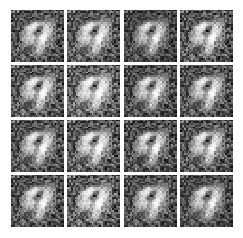


Iter: 500, D: 1.36, G:1.911
Iter: 550, D: 1.593, G:1.841
Iter: 600, D: 1.292, G:1.932
Iter: 650, D: 1.102, G:2.091
Iter: 700, D: 0.8171, G:2.092


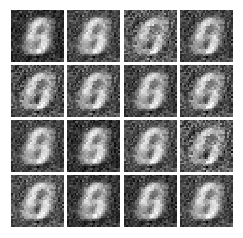


Iter: 750, D: 1.676, G:2.165
Iter: 800, D: 0.8658, G:2.971
Iter: 850, D: 0.8371, G:1.267
Iter: 900, D: 0.9657, G:1.507
Iter: 950, D: 1.253, G:1.279


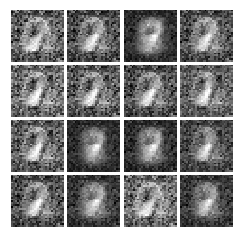


Iter: 1000, D: 0.9104, G:1.968
Iter: 1050, D: 0.9573, G:1.482
Iter: 1100, D: 1.717, G:1.254
Iter: 1150, D: 1.238, G:1.451
Iter: 1200, D: 0.8387, G:1.619


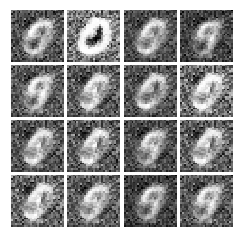


Iter: 1250, D: 1.004, G:1.606
Iter: 1300, D: 1.52, G:2.241
Iter: 1350, D: 1.385, G:1.298
Iter: 1400, D: 0.9759, G:1.552
Iter: 1450, D: 1.382, G:1.311


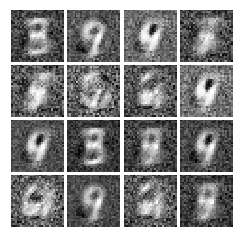


Iter: 1500, D: 1.122, G:1.183
Iter: 1550, D: 1.294, G:1.444
Iter: 1600, D: 1.172, G:1.245
Iter: 1650, D: 1.398, G:1.654
Iter: 1700, D: 1.342, G:1.348


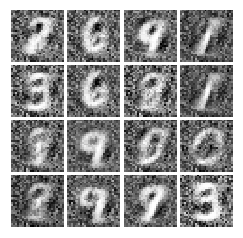


Iter: 1750, D: 1.406, G:1.261
Iter: 1800, D: 1.298, G:1.187
Iter: 1850, D: 1.26, G:1.153
Iter: 1900, D: 1.171, G:1.297
Iter: 1950, D: 1.277, G:0.9835


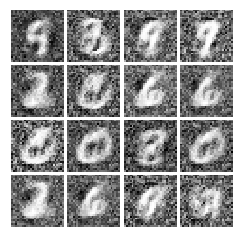


Iter: 2000, D: 1.106, G:1.284
Iter: 2050, D: 1.182, G:1.313
Iter: 2100, D: 1.312, G:0.9777
Iter: 2150, D: 1.172, G:1.437
Iter: 2200, D: 1.223, G:1.514


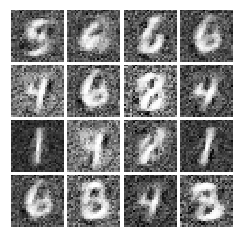


Iter: 2250, D: 1.321, G:1.288
Iter: 2300, D: 1.267, G:1.099
Iter: 2350, D: 1.375, G:1.344
Iter: 2400, D: 1.15, G:1.046
Iter: 2450, D: 1.157, G:1.406


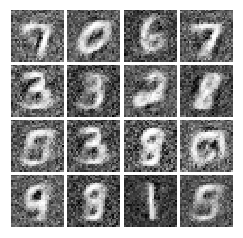


Iter: 2500, D: 1.38, G:1.037
Iter: 2550, D: 1.224, G:1.63
Iter: 2600, D: 1.231, G:1.173
Iter: 2650, D: 1.073, G:1.244
Iter: 2700, D: 1.156, G:1.322


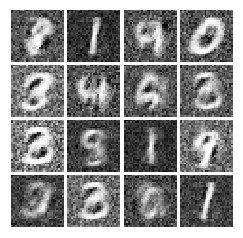


Iter: 2750, D: 1.113, G:1.222
Iter: 2800, D: 1.186, G:1.387
Iter: 2850, D: 1.137, G:1.336
Iter: 2900, D: 1.256, G:1.463
Iter: 2950, D: 0.9823, G:1.597


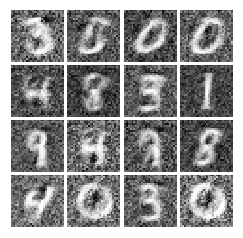


Iter: 3000, D: 1.319, G:1.399
Iter: 3050, D: 1.183, G:1.728
Iter: 3100, D: 1.005, G:1.465
Iter: 3150, D: 1.233, G:1.266
Iter: 3200, D: 0.9933, G:1.607


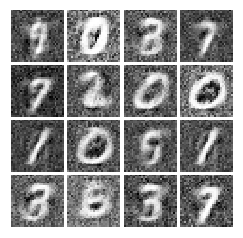


Iter: 3250, D: 1.325, G:1.249
Iter: 3300, D: 1.295, G:1.684
Iter: 3350, D: 1.24, G:0.8774
Iter: 3400, D: 1.058, G:1.692
Iter: 3450, D: 1.098, G:1.36


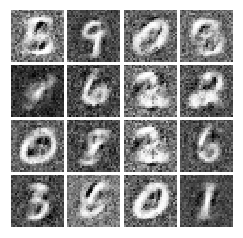


Iter: 3500, D: 1.287, G:1.267
Iter: 3550, D: 1.043, G:1.212
Iter: 3600, D: 1.144, G:1.429
Iter: 3650, D: 1.293, G:1.41
Iter: 3700, D: 1.145, G:1.583


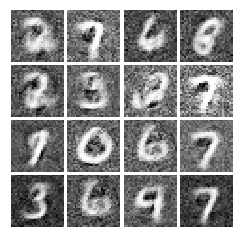


Iter: 3750, D: 1.265, G:1.103
Iter: 3800, D: 1.176, G:1.024
Iter: 3850, D: 1.06, G:1.521
Iter: 3900, D: 1.11, G:1.241
Iter: 3950, D: 1.075, G:1.382


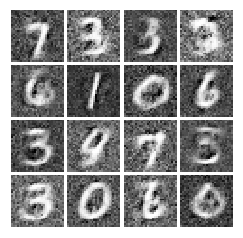


Iter: 4000, D: 1.336, G:1.072
Iter: 4050, D: 1.197, G:1.543
Iter: 4100, D: 1.014, G:1.399
Iter: 4150, D: 1.218, G:1.226
Iter: 4200, D: 1.403, G:1.242


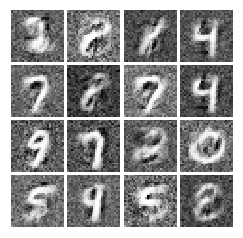


Iter: 4250, D: 1.164, G:1.148
Final images


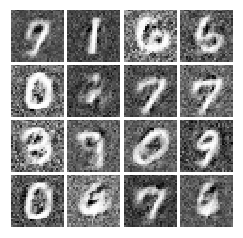

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Conclusion of training 

Compare to Vanila GAN, the images are blury and noisy. It seems that images are put on the top of some white noise. 

# Showing that Vanila Conditional GAN is able to generate the similar looking images by using the labels

In [15]:
def get_fixed_labels(batch_size, label_num):
    """
    Generate the labels to use in the Conditional GAN
    """
    labels = np.zeros((batch_size, 10))
    labels[np.arange(batch_size), label_num] = 1
    return labels

### Generating samples similar to digit $7$

** In the below code, I am using the trick that you can pass values to a tensorflow variables**

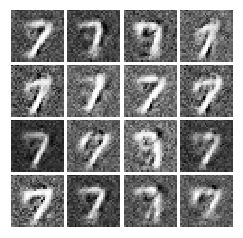

In [16]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 7)})
fig = show_images(samples[:16])
plt.show()

** Conclusion:** There is some confusing in $7$ and $9$.

### Generating samples similar to digit $3$

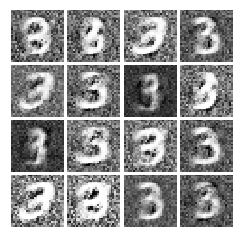

In [17]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 3)})
fig = show_images(samples[:16])
plt.show()

### Why does it work?

In the input of the discriminator, we send the both the original images and labels. So Discrminator figrues out that there is a correlation between labels and images. To fool the discrminator, the generator also has to follow this correlation. 